<h1>Fine-tune Gemma2 with LoRA for Sentiment Analysis</h1>

<center><img src="https://pbs.twimg.com/tweet_video_thumb/GT0-m3kXcAAvW7T.jpg" width=400/></center>

# Introduction

In this notebook, we will experiment with fine-tuning a Gemma 2 model, using quanitzation and low-rank-adaptation combined, i.e. QLoRA.
Here are the steps:

* Load a dataset with sentiments  
* Process it to create balanced train, evaluation and test sets and prepare prompts for LLM
* Prepare quantization config and load tokenizer and model using Transformers
* Define evaluation function
* Test Gemma2 without fine-tuning with prediction of sentiments
* Define fine-tune configuration, parameters and trainer
* Start fine-tuning using SFTTrainer
* Evaluate (using the test set) the fine-tuned model

## Sources for this Notebook

This Notebook is based entirely on three other notebooks:
* [Fine-tune Llama 3 for sentiment analysis](https://www.kaggle.com/code/lucamassaron/fine-tune-llama-3-for-sentiment-analysis) by Luca Massaron
* [Fine-tune Open LLaMA - 81% on Financial Sentiments](https://www.kaggle.com/code/pardeep19singh/fine-tune-open-llama-81-on-financial-sentiments/) by Pardeep Singh
* [Fine-tune Llama 3 with QLoRA for sntiment analysis](https://www.kaggle.com/code/gpreda/fine-tune-llama3-with-qlora-for-sentiment-analysis) by myself (and this one is based heavely on the previous two)

## Data used

The dataset used is [Financial Sentiment Analysis](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis). It combines two sources of data (FiQA, Financial PhraseBank), providing financial sentences, with sentiments added. It can be used to adapt models for sentiment analysis with specialization in financial domain. 


## What is Gemma2?
Gemma2 is the latest release of open-source LLMs from Google DeepMind, with features pretrained and instruction-fine-tuned language models with 2B, 9B and 27B parameters.

## What is LoRA?
LoRA stands for Low-Rank Adaptation. It is a method used to fine-tune large language models (LLMs) by freezing the weights of the LLM and injecting trainable rank-decomposition matrices. The number of trainable parameters during fine-tunning will decrease therefore considerably. According to LoRA paper, this number decreases 10,000 times, and the computational resources size decreases 3 times.

## What is QLoRA?
QLoRA builds on LoRA by incorporating quantization techniques to further reduce memory usage while maintaining, or even enhancing, model performance. With QLoRA it is possible to finetune a 70B parameter model that requires 36 GPUs with only 2!

## What is PEFT?
Parameter-efficient Fine-tuning (PEFT) is a technique used in Natural Language Processing (NLP) to improve the performance of pre-trained language models on specific downstream tasks. It involves reusing the pre-trained model’s parameters and fine-tuning them on a smaller dataset, which saves computational resources and time compared to training the entire model from scratch. PEFT achieves this efficiency by freezing some of the layers of the pre-trained model and only fine-tuning the last few layers that are specific to the downstream task.

## What is SFTTrainer?
SFT in SFTTrainer stands for supervised fine-tuning. The trl (Transformer Reinforcement Learning) library from HuggingFace provides a simple API to fine-tune models using SFTTrainer.


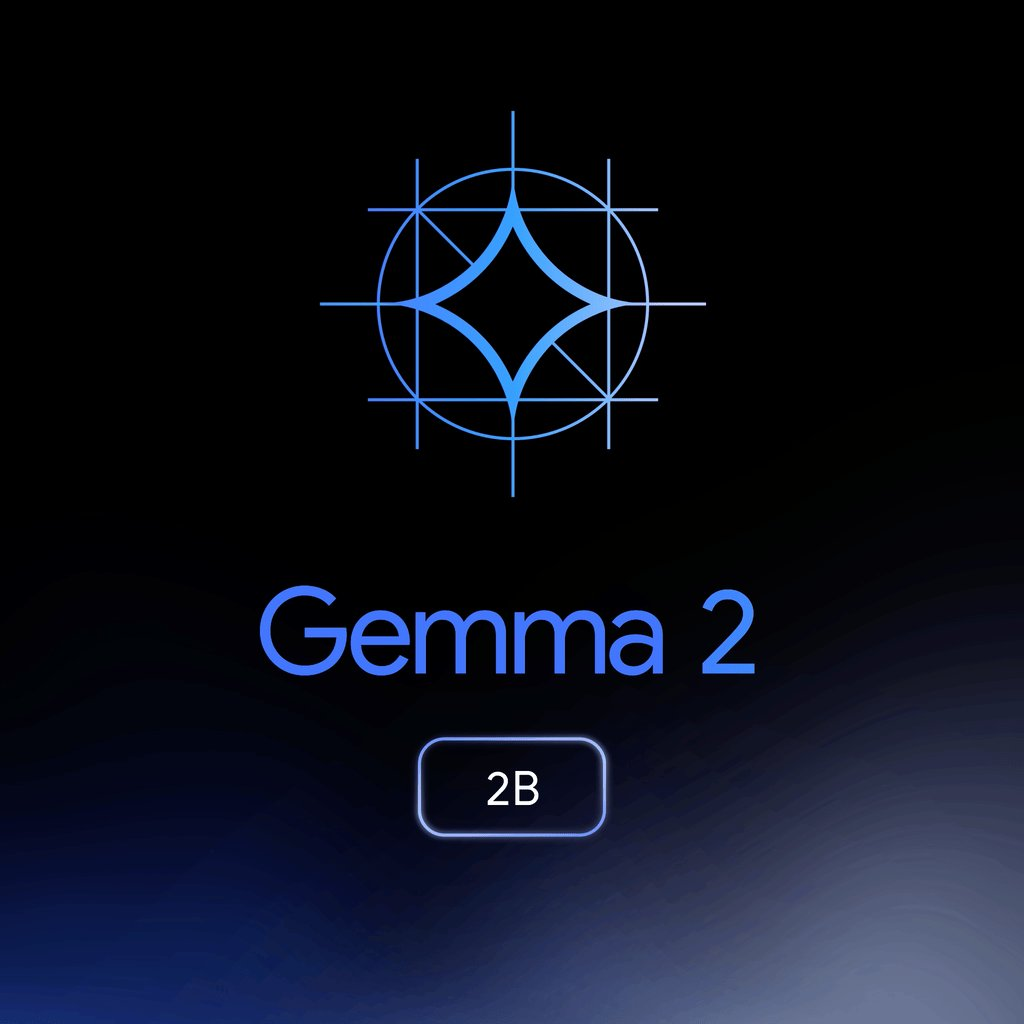
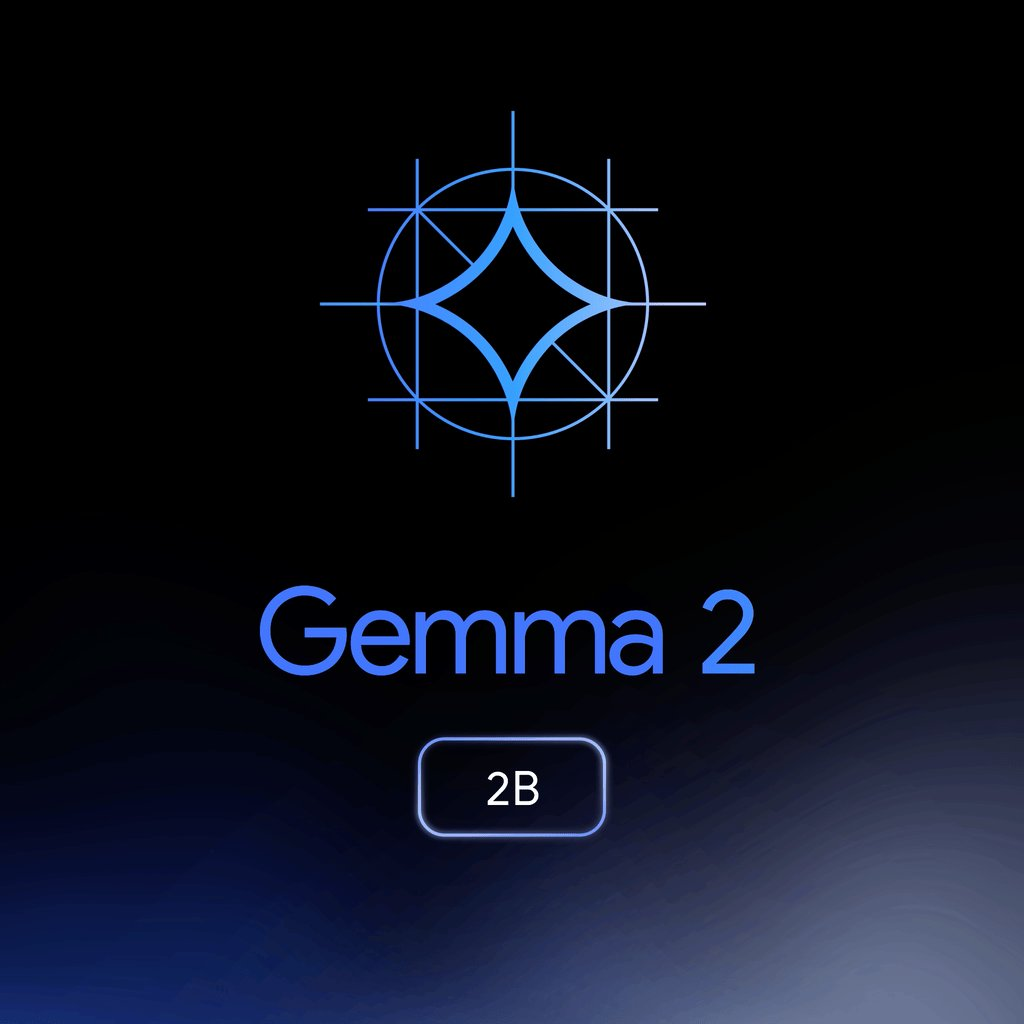

# Prerequisites

We will install the resources needed for importing the libraries (with the correct versions).

In [1]:
## !pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers=="4.40.0"
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Import packages

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.4.0


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


Disabling two features in PyTorch related to memory efficiency and speed during operations on the Graphics Processing Unit (GPU) specifically for the scaled dot product attention (SDPA) function.

In [7]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

# Load the data

In [8]:
filename = "/kaggle/input/financial-sentiment-analysis/data.csv"

df = pd.read_csv(filename, 
                 encoding="utf-8", encoding_errors="replace")

In [9]:
df.columns = ["text", "sentiment"]

In [10]:
df.head()

,text,sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


Sample from each type of sentiment a 

In [11]:
X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

Let's check we got this right.

In [12]:
X_train.shape, X_eval.shape, X_test.shape

((900, 2), (150, 2), (900, 2))

In [13]:
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip()

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["text"]}] = """.strip()


In [14]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

Next we create a function to evaluate the results from our fine-tuned sentiment model. The function performs the following steps:

1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [15]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)

    # Class labels
    class_labels = ['negative', 'neutral', 'positive']

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label `{class_labels[label]}`: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred, target_names=class_labels)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    # Create a heatmap
    plt.figure(figsize=(6, 5))
   
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    
    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Testing the Gemma2 model without fine-tuning

Next we need to take care of the model, which is a 2b-2n(2.6 billion parameters, no RLHF), loading from Kaggle models and quantization.

Model loading and quantization:

* First the code loads the Gemma2 language model from the Kaggle Models.
* Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
* Next, it creates a BitsAndBytesConfig object with the following settings:
    1. load_in_4bit: Load the model weights in 4-bit format.
    2. bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
    3. bnb_4bit_compute_dtype: Use the float16 data type for computations.
    4. bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
* Then the code creates a AutoModelForCausalLM object from the pre-trained Gemma2 language model, using the BitsAndBytesConfig object for quantization.
* After that, the code disables caching for the model.
* Finally the code sets the pre-training token probability to 1.

Tokenizer loading:

* First, the code loads the tokenizer for the Gemma2 language model.
* Then it sets the padding token to be the end-of-sequence (EOS) token.
* Finally, the code sets the padding side to be "right", which means that the input sequences will be padded on the right side. This is crucial for correct padding direction.

In [16]:
model_name = "/kaggle/input/gemma-2/transformers/gemma-2-2b/2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In the next cell, we set a function for predicting the sentiment of a news headline using the Gemma2 language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted.
model: The pre-trained Gemma2 language model.
tokenizer: The tokenizer for the Gemma2 language model.

The function works as follows:
1. For each news headline in the test DataFrame:
    * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
    * Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.
    * Extract the predicted sentiment label from the generated text.
    * Append the predicted sentiment label to the y_pred list.  

  
2. Return the y_pred list.
The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Gemma2 language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [17]:
def predict(test, predictor_model, tokenizer):
    y_pred = []
    
    pipe = pipeline(task="text-generation", 
            model=predictor_model, 
            tokenizer=tokenizer, 
            max_new_tokens = 1, 
            temperature = 0.0,
    )
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

At this point, we are ready to test the Llama 3 8b-chat-hf model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [18]:
y_pred = predict(test, model, tokenizer)

100%|██████████| 900/900 [01:50<00:00,  8.13it/s]


In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the Gemma2 model tends to just predict a negative or neutral sentiment and seldom it detects positive sentiment.

Accuracy: 0.401
Accuracy for label `negative`: 0.500
Accuracy for label `neutral`: 0.593
Accuracy for label `positive`: 0.110

Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.50      0.50       300
     neutral       0.32      0.59      0.42       300
    positive       0.73      0.11      0.19       300

    accuracy                           0.40       900
   macro avg       0.52      0.40      0.37       900
weighted avg       0.52      0.40      0.37       900


Confusion Matrix:
[[150 150   0]
 [110 178  12]
 [ 43 224  33]]


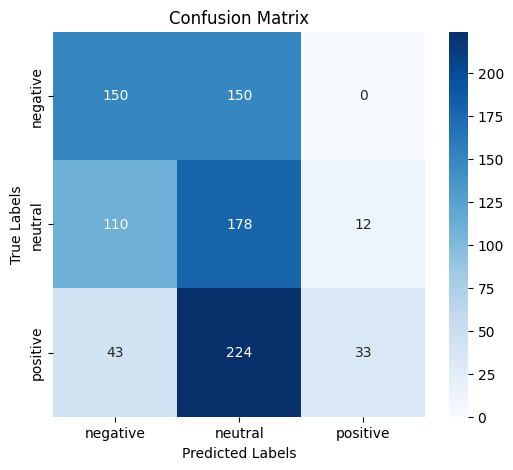

In [19]:
evaluate(y_true, y_pred)

# Fine-tuning Gemma2 model


PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.

TrainingArguments:

The training_arguments object specifies the parameters for training the model. The following are some of the most important parameters:

* output_dir: The directory where the training logs and checkpoints will be saved.
* num_train_epochs: The number of epochs to train the model for.
* per_device_train_batch_size: The number of samples in each batch on each device.
* gradient_accumulation_steps: The number of batches to accumulate gradients before updating the model parameters.
* optim: The optimizer to use for training the model.
* save_steps: The number of steps after which to save a checkpoint.
* logging_steps: The number of steps after which to log the training metrics.
* learning_rate: The learning rate for the optimizer.
* weight_decay: The weight decay parameter for the optimizer.
* fp16: Whether to use 16-bit floating-point precision.
* bf16: Whether to use BFloat16 precision.
* max_grad_norm: The maximum gradient norm.
* max_steps: The maximum number of steps to train the model for.
* warmup_ratio: The proportion of the training steps to use for warming up the learning rate.
* group_by_length: Whether to group the training samples by length.
* lr_scheduler_type: The type of learning rate scheduler to use.
* report_to: The tools to report the training metrics to.
* evaluation_strategy: The strategy for evaluating the model during training.

SFTTrainer:

The SFTTrainer is a custom trainer class from the TRL library. It is used to train large language models (also using the PEFT method).

The SFTTrainer object is initialized with the following arguments:

* model: The model to be trained.
* train_dataset: The training dataset.
* eval_dataset: The evaluation dataset.
* peft_config: The PEFT configuration.
* dataset_text_field: The name of the text field in the dataset.
* tokenizer: The tokenizer to use.
* args: The training arguments.
* packing: Whether to pack the training samples.
* max_seq_length: The maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model by calling the train() method

In [20]:
from sklearn.metrics import (accuracy_score, 
                             recall_score, 
                             precision_score, 
                             f1_score)

from transformers import EarlyStoppingCallback, IntervalStrategy

def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [21]:
output_dir="trained_weigths"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                   
    num_train_epochs=5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25, 
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    },
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

The following code will train the model using the trainer.train() method and then save the trained model to the trained-model directory. Using The standard GPU P100 offered by Kaggle, the training should be quite fast.

In [22]:
# Train model
trainer.train()

Step,Training Loss
25,3.459600
50,1.101600
75,1.052500
100,0.981500
125,0.896500
150,0.784300
175,0.790700
200,0.783600
225,0.776300
250,0.542500


TrainOutput(global_step=560, training_loss=0.6884942595447813, metrics={'train_runtime': 2337.0954, 'train_samples_per_second': 1.925, 'train_steps_per_second': 0.24, 'total_flos': 4730090431348224.0, 'train_loss': 0.6884942595447813, 'epoch': 4.977777777777778})

The model and the tokenizer are saved to disk for later usage.

In [23]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.model',
 'trained_weigths/added_tokens.json',
 'trained_weigths/tokenizer.json')

# Testing the fine-tuned model

Let's see what is the classification report for the evaluation set.

In [24]:
trained_model_name = "/kaggle/working/trained_weigths/checkpoint-560"
trained_model = AutoModelForCausalLM.from_pretrained(
    trained_model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

trained_model.config.use_cache = False
trained_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
y_trained_pred = predict(test, trained_model, tokenizer)

100%|██████████| 900/900 [02:10<00:00,  6.88it/s]


Accuracy: 0.764
Accuracy for label `negative`: 0.920
Accuracy for label `neutral`: 0.837
Accuracy for label `positive`: 0.537

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.92      0.87       300
     neutral       0.64      0.84      0.72       300
    positive       0.96      0.54      0.69       300

    accuracy                           0.76       900
   macro avg       0.81      0.76      0.76       900
weighted avg       0.81      0.76      0.76       900


Confusion Matrix:
[[276  19   5]
 [ 48 251   1]
 [ 14 125 161]]


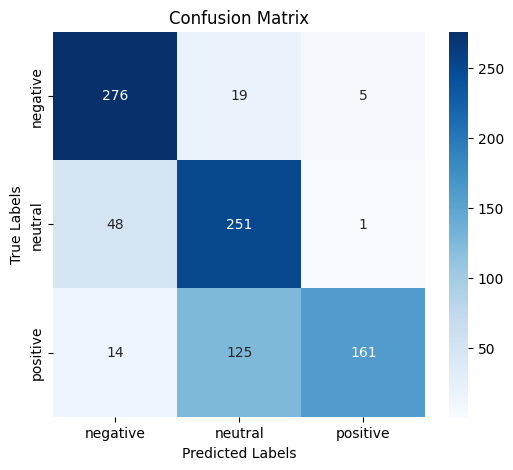

In [26]:
evaluate(y_true, y_trained_pred)

# Publish the model

Next, we are using **kagglehub** library to publish the fine-tuned model as a Kaggle Model.

A new model card will be created (if not existent). Alternatively, if the model was already published, a new model version will be created.

In [27]:
import kagglehub
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("kaggle_username")
os.environ["KAGGLE_KEY"] = user_secrets.get_secret("kaggle_key")

In [28]:
kaggle_username = os.environ["KAGGLE_USERNAME"]

kaggle_uri = f"{kaggle_username}/gemma2-sentiment-analysis/transformers/gemma2_2b_en_sentiment_analysis"
kagglehub.model_upload(kaggle_uri, trained_model_name, 'Apache 2.0')

Uploading Model https://www.kaggle.com/models/gpreda/gemma2-sentiment-analysis/transformers/gemma2_2b_en_sentiment_analysis ...
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/tokenizer.json


Uploading: 100%|██████████| 34.4M/34.4M [00:01<00:00, 17.8MB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/tokenizer.json (33MB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/training_args.bin


Uploading: 100%|██████████| 5.56k/5.56k [00:00<00:00, 7.48kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/training_args.bin (5KB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/tokenizer.model


Uploading: 100%|██████████| 4.24M/4.24M [00:01<00:00, 3.39MB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/tokenizer.model (4MB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/tokenizer_config.json


Uploading: 100%|██████████| 46.4k/46.4k [00:00<00:00, 119kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/tokenizer_config.json (45KB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/adapter_model.safetensors


Uploading: 100%|██████████| 332M/332M [00:08<00:00, 38.5MB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/adapter_model.safetensors (317MB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/README.md


Uploading: 100%|██████████| 5.12k/5.12k [00:00<00:00, 15.7kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/README.md (5KB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/adapter_config.json


Uploading: 100%|██████████| 747/747 [00:00<00:00, 2.21kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/adapter_config.json (747B)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/trainer_state.json


Uploading: 100%|██████████| 4.53k/4.53k [00:00<00:00, 13.9kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/trainer_state.json (4KB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/rng_state.pth


Uploading: 100%|██████████| 14.2k/14.2k [00:00<00:00, 43.3kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/rng_state.pth (14KB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/optimizer.pt


Uploading: 100%|██████████| 665M/665M [00:16<00:00, 39.7MB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/optimizer.pt (634MB)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/special_tokens_map.json


Uploading: 100%|██████████| 522/522 [00:00<00:00, 1.60kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/special_tokens_map.json (522B)
Starting upload for file /kaggle/working/trained_weigths/checkpoint-560/scheduler.pt


Uploading: 100%|██████████| 1.06k/1.06k [00:00<00:00, 3.27kB/s]

Upload successful: /kaggle/working/trained_weigths/checkpoint-560/scheduler.pt (1KB)


Your model instance version has been created.
Files are being processed...
See at: https://www.kaggle.com/models/gpreda/gemma2-sentiment-analysis/transformers/gemma2_2b_en_sentiment_analysis


# Conclusions

The evaluation shows good results, compared with the result without fine-tuning. Accuracy, precision, recall and f1-score all improved.

The fine-tuned model was then published.
